### set another directory for unsupervised analysis

In [66]:
cd /usr/local/notebooks

/usr/local/notebooks


In [35]:
mkdir -p ./workdir/clust

In [44]:
Prefix='SS'    # name for the analysis run
Script_dir='./SSUsearch/scripts'
Wkdir='./workdir'
Mcclust_jar='./external_tools/Clustering/dist/Clustering.jar'
Java_xmx='10g'
Java_gc_threads='2'
Otu_dist_cutoff='0.05'
Design='./data/test/SS.design'


In [62]:
# get absolute path
import os
Script_dir=os.path.abspath(Script_dir)
Wkdir=os.path.abspath(Wkdir)
Mcclust_jar=os.path.abspath(Mcclust_jar)
Design=os.path.abspath(Design)

os.environ.update(
    {'Prefix':Prefix, 
     'Script_dir': Script_dir, 
     'Wkdir': Wkdir, 
     'Mcclust_jar': Mcclust_jar, 
     'Java_xmx':Java_xmx, 
     'Java_gc_threads':Java_gc_threads, 
     'Otu_dist_cutoff':Otu_dist_cutoff, 
     'Design': Design})

In [67]:
cd ./workdir/clust

/usr/local/notebooks/workdir/clust


In [ ]:
!sed -i 's/:/_/g' $Wkdir/*.ssu.out/*.forclust
!echo "*** Replace ':' with '_' in seq names (original illumina name has ':' in them)"

In [48]:
cat $Wkdir/*.ssu.out/*.forclust > combined_seqs.afa

In [49]:
# make group file for mcclust and mothur. 
# first part of the file basename will be the group label, e.g. file "aa.bb.cc" will have "aa" as group label.
!python $Script_dir/make-groupfile.py $Prefix.groups $Wkdir/*.ssu.out/*.forclust

input is list of files..


In [50]:
!echo "*** Starting mcclust derep"
!time java -Xmx$Java_xmx -XX:+UseParallelOldGC -XX:ParallelGCThreads=$Java_gc_threads \
    -jar $Mcclust_jar derep -a -o derep.fasta \
    temp.mcclust.names temp.txt combined_seqs.afa
    
!rm temp.txt

*** Starting mcclust derep
Processing combined_seqs.afa
Total sequences: 199
Unique sequences: 174
Dereplication complete: 499
0.62user 0.14system 0:00.84elapsed 90%CPU (0avgtext+0avgdata 354992maxresident)k
1936inputs+192outputs (1major+23117minor)pagefaults 0swaps


In [51]:
# convert mcclust names to mothur names
!python $Script_dir/mcclust2mothur_names_file.py temp.mcclust.names temp.mothur.names

In [53]:
!echo "starting preclust.."
### output: derep.precluster.fasta, derep.precluster.names
!mothur "#pre.cluster(fasta=derep.fasta, diffs=1, name=temp.mothur.names)"

starting preclust..






mothur v.1.34.4
Last updated: 12/22/2014

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > pre.cluster(fasta=derep.fasta, diffs=1, name=temp.mothur.names)

Using 1 processors.
0	174	0
100	165	9
174	163	11
Total number of sequences before precluster was 174.
pre.cluster removed 11 sequences.

It took 0 secs to cluster 174 sequences.

Output File Names: 
derep.precluster.fasta
derep.precluster.names
derep.precluster.map


mothur > quit()


In [54]:
!python $Script_dir/mothur2mcclust_names_file.py derep.precluster.names $Prefix.names

In [55]:
!time java -Xmx$Java_xmx -XX:+UseParallelOldGC -XX:ParallelGCThreads=$Java_gc_threads \
    -jar $Mcclust_jar dmatrix \
    -l 25 -o matrix.bin -i $Prefix.names -I derep.precluster.fasta

Reading sequences(memratio=1.2895267219085598E-4)...
Using distance model edu.msu.cme.rdp.alignment.pairwise.rna.UncorrectedDistanceModel
Read 163 Nucleotide sequences (memratio=2.579355191410434E-4)
Reading ID Mapping from file /usr/local/notebooks/SS.names
Read mapping for 199 sequences (memratio=3.8690076414828753E-4)
Starting distance computations, predicted max edges=26569, at=Mon Jun 22 21:42:46 UTC 2015
Dumping 13203 edges to partial_matrix0 FINAL EDGES (memory ratio=0.001850005274547931)
Matrix edges computed: 129
Maximum distance: 0.5238095238095238
Splits: 1
Partition files merged: 102
0.60user 0.08system 0:00.55elapsed 124%CPU (0avgtext+0avgdata 201776maxresident)k
1872inputs+376outputs (0major+14881minor)pagefaults 0swaps


In [56]:
!time java -Xmx$Java_xmx -XX:+UseParallelOldGC -XX:ParallelGCThreads=$Java_gc_threads \
    -jar $Mcclust_jar cluster -m upgma \
    -i $Prefix.names -s $Prefix.groups -o complete.clust -d matrix.bin

!python $Script_dir/mcclust2mothur-list-cutoff.py complete.clust $Prefix.list $Otu_dist_cutoff


lambda=0
Clustering complete: 619
Lookaheads performed: 0
Time spent Looking ahead: 0
1.33user 0.15system 0:00.79elapsed 188%CPU (0avgtext+0avgdata 284992maxresident)k
368inputs+744outputs (0major+20127minor)pagefaults 0swaps
File(s):	1c 1d 2c 2d 

Sequences:	50 49 50 50 

*** Replace ':' with '_' in seq names (original illumina name has ':' in them)


In [57]:
!java -jar $Mcclust_jar rep-seqs -c -l -s complete.clust $Otu_dist_cutoff combined_seqs.afa
!mv complete.clust_rep_seqs.fasta otu_rep_align.fa

In [58]:
!mothur "#make.shared(list=$Prefix.list, group=$Prefix.groups, label=$Otu_dist_cutoff);"
!cat $Wkdir/*.ssu.out/*.silva.taxonomy > $Prefix.taxonomy
!mothur "#classify.otu(list=$Prefix.list, taxonomy=$Prefix.taxonomy, label=$Otu_dist_cutoff)"
!mothur "#make.biom(shared=$Prefix.shared, constaxonomy=$Prefix.$Otu_dist_cutoff.cons.taxonomy)"
!mv $Prefix.$Otu_dist_cutoff.biom $Prefix.biom







mothur v.1.34.4
Last updated: 12/22/2014

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > make.shared(list=SS.list, group=SS.groups, label=0.05)
0.05

Output File Names: 
SS.shared
SS.1c.rabund
SS.1d.rabund
SS.2c.rabund
SS.2d.rabund


mothur > quit()






mothur v.1.34.4
Last updated: 12/22/2014

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independ

In [59]:
# clean up tempfiles
!rm -f mothur.*.logfile *rabund complete* derep.fasta matrix.bin nonoverlapping.bin temp.*

### With SS.groups, SS.names and SS.list, most diversity analysis can be done by mothur. You can look at [mothur wiki](http://www.mothur.org/wiki/454_SOP) for details (Do not forgot to do even sampling before beta-diversity analysis).

### SS.biom file can used in most tools. (qiime and rdp)



In [60]:
%%bash

#since The purpose of this tutorial is to show our new pipeline, we will skip details of community analysis with mothur
#following are some common commands in mothur

# mothur is inconsistent with the "Label" in files names. I have seens either "dummy" or "useLabel“
# "dummy" for 1.33.3; "userLabel" for 1.34.4
Label=userLabel
#Label=dummy
mothur "#make.shared(biom=$Prefix.biom); sub.sample(shared=$Prefix.shared); summary.single(calc=nseqs-coverage-sobs-chao-shannon-invsimpson); dist.shared(calc=braycurtis); pcoa(phylip=$Prefix.$Label.subsample.braycurtis.$Label.lt.dist); nmds(phylip=$Prefix.$Label.subsample.braycurtis.$Label.lt.dist); amova(phylip=$Prefix.$Label.subsample.braycurtis.$Label.lt.dist, design=$Design); tree.shared(calc=braycurtis); unifrac.weighted(tree=$Prefix.$Label.subsample.braycurtis.$Label.tre, group=$Design, random=T)"
rm -f mothur.*.logfile; 
rm -f *.rabund







mothur v.1.34.4
Last updated: 12/22/2014

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > make.shared(biom=SS.biom)

userLabel

Output File Names: 
SS.shared
SS.1c.rabund
SS.1d.rabund
SS.2c.rabund
SS.2d.rabund


mothur > sub.sample(shared=SS.shared)
Sampling 49 from each group.
userLabel

Output File Names: 
SS.userLabel.subsample.shared


mothur > summary.single(calc=nseqs-coverage-sobs-chao-shannon-invsimpson)
Using SS.userLabel.subsample.shared as input file for the shared parameter.

Processing group 1c

userLabel



In [61]:
!echo "This part of pipeline finishes successfully :)"

This part of pipeline finishes successfully :)


In [ ]:
### some simple visualization

In [91]:
%%bash

Label=userLabel
#Label=dummy

# alpha diveristy index
python $Script_dir/plot-diversity-index.py $Label "chao,shannon,invsimpson" "c,d" "SS.$Label.subsample.groups.summary" "test" "test.alpha" 

2 samples collect for Kw c
2 samples collect for Kw d
2 samples collect for Kw c
2 samples collect for Kw d
2 samples collect for Kw c
2 samples collect for Kw d


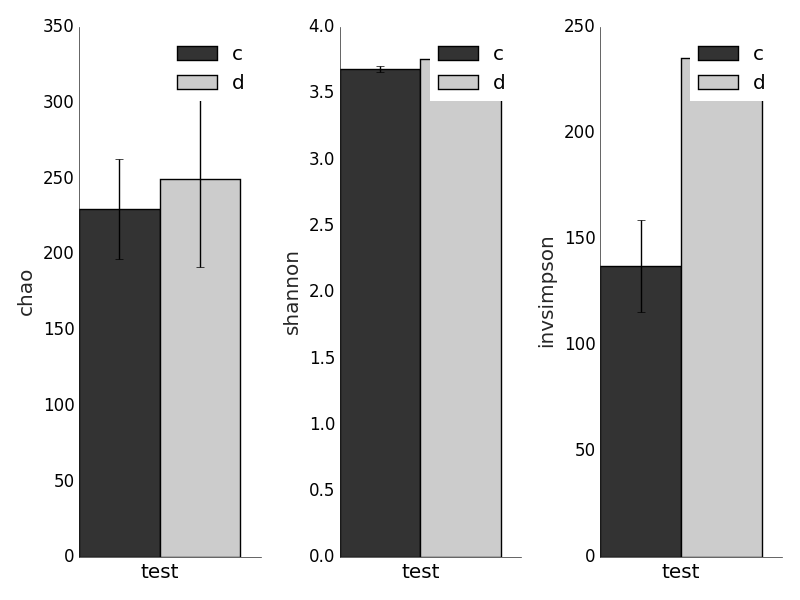

In [93]:
from IPython.display import Image
Image('test.alpha.png')

In [87]:
# taxon distribution
!python $Script_dir/plot-taxa-count.py 2 test.taxa.dist ../*.ssu.out/*.silva.taxonomy.count

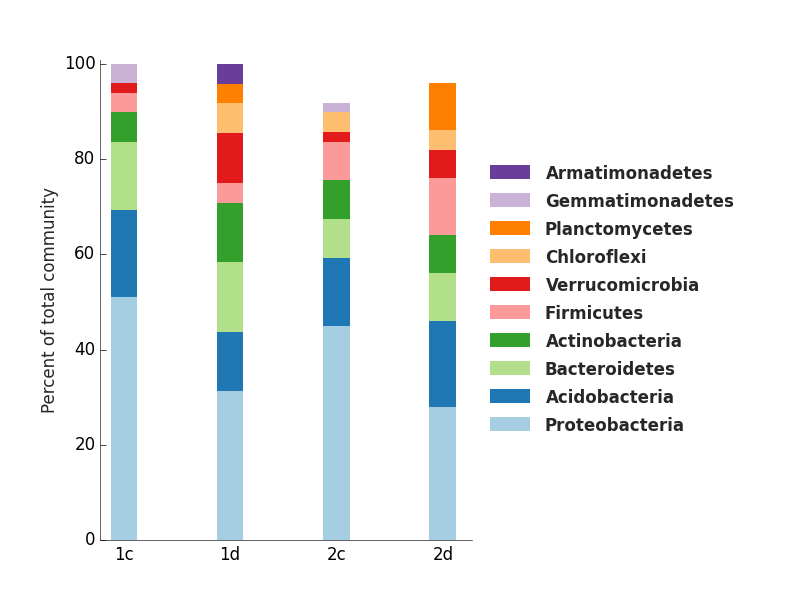

In [89]:
from IPython.display import Image
Image('test.taxa.dist.png')

In [101]:
%%bash

Label=userLabel
#Label=dummy

# ordination
python $Script_dir/plot-pcoa.py  SS.$Label.subsample.braycurtis.$Label.lt.pcoa.axes  SS.$Label.subsample.braycurtis.$Label.lt.pcoa.loadings  test.beta.pcoa

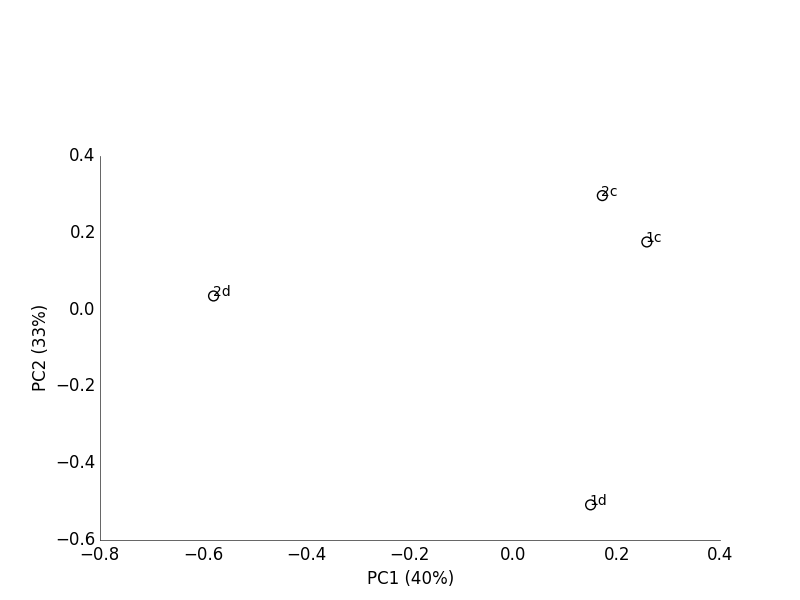

In [102]:
from IPython.display import Image
Image('test.beta.pcoa.png')